# ACTIVIDAD 2. Problemas de Clasificación

A01285158 | Grace Aviance

## EJERCICIO 1

En estos archivos se tienen datos procesados de un experimento de psicología en el que se mide la respuesta cerebral cuando un sujeto presta atención a un estímulo visual que aparece de manera repentina y cuando no presta atención a dicho estímulo visual. 

Los datos están en archivos de texto, los cuales se cargan con la función loadtxt de numpy (https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html)

- La primera columna corresponde a la clase (1 o 2). 
- La clase 1 representa cuando el sujeto está prestando atención, y la clase 2 cuando no lo hace. 
- La segunda columna se ignora, mientras que el resto de las columnas indican las variables que se calcularon de la respuesta cerebral medida con la técnicas de Electroencefaolografía para cada caso.

Para tu conjunto de datos:

1. Determina si es necesario balancear los datos. En caso de que sea afirmativo, en todo este ejercicio tendrás que utilizar alguna estrategia para mitigar el problema de tener una muestra desbalanceada.

2. Evalúa al menos 8 modelos de clasificación distintos utilizando validación cruzada, y determina cuál de ellos es el más efectivo.

3. Implementa desde cero el método de regresión logística, y evalúalo con el conjunto de datos. 

4. Con alguno de los clasificadores que probaste en los pasos anteriores, determina el número óptimo de características utilizando un método tipo Filter.

5. Repite el paso anterior, pero para un método de selección de características secuencial.

6. Repite el paso 4, pero para un método de selección de características recursivo.

7. Escoge alguna de las técnicas de selección de características que probaste con anteioridad, y con el número óptimo de características encontrado, prepara tu modelo para producción haciendo lo siguiente:
a. Aplica el método de selección de características con todos los datos.
b. Ajusta el modelo con las características encontradas.

8. Contesta las siguientes preguntas:

- A) ¿Qué pasa si no se considera el problema de tener datos desbalanceados para este caso? ¿Por qué?

- B) De todos los clasificadores, ¿cuál o cuales consideras que son adecuados para los datos? ¿Qué propiedades tienen dichos modelos que los hacen apropiados para los datos? Argumenta tu respuesta.

- C) ¿Es posibles reducir la dimensionalidad del problema sin perder rendimiento en el modelo? ¿Por qué?
 
- D) ¿Qué método de selección de características consideras el más adecuado para este caso? ¿Por qué?

- E) Si quisieras mejorar el rendimiento de tus modelos, ¿qué más se podría hacer?

In [1]:
import numpy as np
import pandas as pd

df_txt = np.loadtxt("P1_5.txt")
df = pd.DataFrame(df_txt)
df.drop(columns = 1, inplace = True)

In [2]:
df.head()

,0,2,3,4,5,6,7,8,9,10,...,145,146,147,148,149,150,151,152,153,154
0,1.0,6.778645,5.554810,4.935933,5.639114,6.603463,6.309278,4.738829,3.110043,2.167682,...,0.129900,-0.609716,-0.822197,-0.109120,0.899585,1.374105,1.187913,0.742605,0.347446,0.131211
1,1.0,-0.354725,-0.210143,-0.337065,-0.613978,-0.725109,-0.509282,-0.154146,0.062651,0.102172,...,-0.468649,-0.052648,0.544180,0.781654,0.833143,1.253793,1.914558,2.013101,1.287430,0.521264
2,1.0,1.727716,2.056163,1.876898,0.992565,0.224456,0.429907,1.229387,1.403841,0.507216,...,-0.365350,-0.827163,0.208835,1.473647,1.545710,0.672175,0.097850,0.288585,0.679454,0.822155
3,1.0,1.064721,1.299112,0.705400,0.422355,1.269587,2.672225,3.240471,2.234018,0.275905,...,0.026794,-0.726883,-0.768780,-0.600054,-0.948638,-1.688718,-1.858080,-0.862087,0.660512,1.426284
4,1.0,-0.010284,-0.097968,-0.345274,-0.216691,0.351261,0.781839,0.695825,0.298840,-0.198690,...,1.946469,0.730151,-0.396311,-0.324040,0.629645,1.199808,0.600917,-0.806892,-2.087005,-2.579933


In [3]:
X = df.drop(columns = 0)
y = df.loc[:,0] - 1 # For simplicity in future model training
y = y.replace({0: 1, 1: 0})

### 1. Determinar si el conjunto de datos es desbalanceado

In [4]:
notP300_count = len(y[y == 0])
P300_count = len(y[y == 1])
(notP300_count, P300_count)

(1689, 281)

In [5]:
prior_0 = len(y[y == 0]) / len(y)
prior_1 = len(y[y == 1]) / len(y)
(prior_0, prior_1)

(0.8573604060913705, 0.14263959390862943)

#### En efecto, el conjunto de datos está desbalanceado. Más del 85% de las muestras están estiquitadas como no P300, y menos del 15% está etiquetada como P300.

In [8]:
# Eight Classifiers
from sklearn.svm import SVC # Linear and RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

# Cross-validation and metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
import random

### 2. Evalúa al menos 8 modelos de clasificación distintos utilizando validación cruzada, y determina cuál de ellos es el más efectivo.

In [9]:
# Función para evaluar un modelo con validación cruzada, y manejo de desbalanceo con subsampling y función de pérdida ponderada (en caso de estar incluida en sklearn)

def evaluate_model(X, y, classifier, balance_param_name=None, balance_param_value=None):
    """
    Función para evaluar modelos utilizando validación cruzada, aplicando subsampling 
    y, si es aplicable, incluir un parámetro personalizado para manejar desbalanceo de datos.

    Parámetros:
    X (pd.DataFrame): Características
    y (pd.Series): Etiquetas
    classifier: Modelo clasificador a evaluar
    balance_param_name (str): Nombre del parámetro para manejar desbalanceo (ej: 'class_weight')
    balance_param_value (any): Valor del parámetro de desbalanceo (ej: 'balanced')

    Retorna:
    None: Imprime el reporte de clasificación de la validación cruzada.
    """

    # Validación cruzada
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    
    cv_y_test = []
    cv_y_pred = []

    # Aplicamos subsampling en cada pliegue
    for train_index, test_index in kf.split(X, y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]

        # Subsampling: balancear las clases haciendo muestreo aleatorio de la clase mayoritaria
        X1 = X_train[y_train == 0]  # Datos de la clase 1
        y1 = y_train[y_train == 0]
        n1 = len(y1)

        X2 = X_train[y_train == 1]  # Datos de la clase 2
        y2 = y_train[y_train == 1]
        n2 = len(y2)

        

        # Muestreo aleatorio de la clase mayoritaria
        ind = random.choices(list(X2.index), k=n1)  # Igualar el número de muestras
        X_sub = pd.concat([X1, X2.loc[ind]])
        y_sub = pd.concat([y1, y2.loc[ind]])

        # Entrenar el modelo con subsampling
        classifier.fit(X_sub, y_sub)

        # Fase de prueba
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        y_pred = classifier.predict(X_test)

        # Guardar predicciones y etiquetas reales
        cv_y_test.append(y_test)
        cv_y_pred.append(pd.Series(y_pred, index=y_test.index))

    # Concatenar predicciones y etiquetas
    y_test_concat = pd.concat(cv_y_test)
    y_pred_concat = pd.concat(cv_y_pred)

    # Imprimir reporte de clasificación con subsampling
    print(f"--- Reporte de clasificación con subsampling ---")
    print(classification_report(y_test_concat, y_pred_concat))

    # Evaluación adicional con un parámetro de balanceo (si se ha proporcionado)
    if balance_param_name and balance_param_value:
        # Crear una copia del clasificador con el parámetro de balanceo aplicado
        classifier_with_balance = classifier.set_params(**{balance_param_name: balance_param_value})

        cv_y_test_balanced = []
        cv_y_pred_balanced = []

        for train_index, test_index in kf.split(X, y):
            # Entrenamos el modelo con el parámetro de balanceo sin subsampling
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            classifier_with_balance.fit(X_train, y_train)

            # Fase de prueba
            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]
            y_pred_balanced = classifier_with_balance.predict(X_test)

            # Guardar predicciones y etiquetas reales
            cv_y_test_balanced.append(y_test)
            cv_y_pred_balanced.append(pd.Series(y_pred_balanced, index=y_test.index))

        # Concatenar predicciones y etiquetas
        y_test_concat_balanced = pd.concat(cv_y_test_balanced)
        y_pred_concat_balanced = pd.concat(cv_y_pred_balanced)

        # Imprimir reporte de clasificación con el parámetro de balanceo
        print(f"--- Reporte de clasificación con {balance_param_name}={balance_param_value} ---")
        print(classification_report(y_test_concat_balanced, y_pred_concat_balanced))

#### Modelo 1. K-Nearest-Neighbors

In [16]:
evaluate_model(X, y, KNeighborsClassifier(n_neighbors=5))

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.94      0.80      0.86      1689
         1.0       0.36      0.67      0.47       281

    accuracy                           0.78      1970
   macro avg       0.65      0.74      0.67      1970
weighted avg       0.85      0.78      0.81      1970



#### Modelo 2. Linear Discriminant Analysis

In [17]:
evaluate_model(X, y, LinearDiscriminantAnalysis(), balance_param_name='priors', balance_param_value=[prior_0, prior_1])

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      1689
         1.0       0.51      0.80      0.62       281

    accuracy                           0.86      1970
   macro avg       0.74      0.84      0.77      1970
weighted avg       0.90      0.86      0.87      1970

--- Reporte de clasificación con priors=[0.8573604060913705, 0.14263959390862943] ---
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1689
         1.0       0.74      0.61      0.67       281

    accuracy                           0.91      1970
   macro avg       0.84      0.79      0.81      1970
weighted avg       0.91      0.91      0.91      1970



#### Modelo 3. Gaussian Naive-Bayes

In [18]:
evaluate_model(X, y, GaussianNB(), balance_param_name='priors', balance_param_value=[prior_0, prior_1])

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      1689
         1.0       0.39      0.35      0.37       281

    accuracy                           0.83      1970
   macro avg       0.64      0.63      0.64      1970
weighted avg       0.82      0.83      0.83      1970

--- Reporte de clasificación con priors=[0.8573604060913705, 0.14263959390862943] ---
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1689
         1.0       0.48      0.30      0.37       281

    accuracy                           0.85      1970
   macro avg       0.69      0.62      0.64      1970
weighted avg       0.83      0.85      0.84      1970



#### Modelo 4. Linear Support Vector Classifier

In [19]:
evaluate_model(X, y, SVC(kernel='linear'), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      1689
         1.0       0.56      0.83      0.67       281

    accuracy                           0.88      1970
   macro avg       0.77      0.86      0.80      1970
weighted avg       0.91      0.88      0.89      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      1689
         1.0       0.53      0.82      0.64       281

    accuracy                           0.87      1970
   macro avg       0.75      0.85      0.78      1970
weighted avg       0.90      0.87      0.88      1970



#### Modelo 5. Radial Support Vector Classifier

In [20]:
evaluate_model(X, y, SVC(kernel='rbf'), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1689
         1.0       0.67      0.78      0.72       281

    accuracy                           0.91      1970
   macro avg       0.82      0.86      0.84      1970
weighted avg       0.92      0.91      0.92      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1689
         1.0       0.68      0.77      0.72       281

    accuracy                           0.91      1970
   macro avg       0.82      0.86      0.84      1970
weighted avg       0.92      0.91      0.92      1970



#### Modelo 6. Desicion Tree

In [21]:
evaluate_model(X, y, DecisionTreeClassifier(), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91      1689
         1.0       0.49      0.50      0.49       281

    accuracy                           0.85      1970
   macro avg       0.70      0.71      0.70      1970
weighted avg       0.85      0.85      0.85      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1689
         1.0       0.46      0.46      0.46       281

    accuracy                           0.84      1970
   macro avg       0.68      0.68      0.68      1970
weighted avg       0.84      0.84      0.84      1970



#### Modelo 7. Random Forest

In [22]:
evaluate_model(X, y, RandomForestClassifier(), balance_param_name='class_weight', balance_param_value='balanced')

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      1689
         1.0       0.88      0.38      0.53       281

    accuracy                           0.90      1970
   macro avg       0.90      0.69      0.74      1970
weighted avg       0.90      0.90      0.89      1970

--- Reporte de clasificación con class_weight=balanced ---
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94      1689
         1.0       0.91      0.19      0.31       281

    accuracy                           0.88      1970
   macro avg       0.90      0.59      0.62      1970
weighted avg       0.89      0.88      0.85      1970



#### Modelo 8. XGBoost

In [23]:
evaluate_model(X, y, XGBClassifier(), balance_param_name='scale_pos_weight', balance_param_value=len(y[y == 0])/len(y[y == 1]))

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1689
         1.0       0.73      0.63      0.68       281

    accuracy                           0.91      1970
   macro avg       0.84      0.80      0.81      1970
weighted avg       0.91      0.91      0.91      1970

--- Reporte de clasificación con scale_pos_weight=6.01067615658363 ---
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1689
         1.0       0.73      0.62      0.67       281

    accuracy                           0.91      1970
   macro avg       0.83      0.79      0.81      1970
weighted avg       0.91      0.91      0.91      1970



### 3. Logistic Regression from Scratch

In [24]:
# Sigmoid Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class LogisticRegression:
    
    def __init__(self, lr=0.001, n_iters=1000):
        self.lr = lr #Learning rate
        self.n_iters = n_iters #Number of epochs
        self.weights = None # Weights
        self.bias = None # Bias
        
    def fit(self, X, y):
        # Define key variables
        n_samples, n_features = X.shape
        
        #Initialize weights and bias with zeros
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Train the model for n_iters times
        for _ in range(self.n_iters):
            # Get predictions
            linear_pred = np.dot(X, self.weights) + self.bias # y = mx + b
            predictions = sigmoid(linear_pred) # fit our linear predictions into the sigmoid function
            
            # Calculate the Gradients
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)
    
            # Compute new weights and biases
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias # y = mx + b
        y_pred = sigmoid(linear_pred) # fit our linear predictions into the sigmoid functio
        class_pred = [0 if y <= 0.5 else 1 for y in y_pred] # assign a class to our predictions
        return np.array(class_pred)

In [25]:
evaluate_model(X, y, LogisticRegression())

--- Reporte de clasificación con subsampling ---
              precision    recall  f1-score   support

         0.0       0.99      0.67      0.80      1689
         1.0       0.32      0.94      0.48       281

    accuracy                           0.71      1970
   macro avg       0.65      0.81      0.64      1970
weighted avg       0.89      0.71      0.75      1970



### 4. Con alguno de los clasificadores que probaste en los pasos anteriores, determina el número óptimo de características utilizando un método tipo Filter.

#### Modelo seleccionado: Radial Support Vector Classifier con weight loss function

Se optó por este modelo ya que tiene un buen recall para la clase no dominante (0.79), lo cual quiere decir que detectó casi el 80% de las señales P300. Además tiene el f1-score para la clase no dominante (0.72) más alto entre todos los modelos evaluados, lo cual indica tuvo la mejor proporción entre recall y precision para la clase no dominante. Finalmente, tuvo un accuracy de 0.91.

Sin embargo, este modelo no es recomendado para algunos de los métodos de selección de características, de hecho solo se recomienda usar filter ya que no requiere entrenamiento de modelo previo a seleccionar las características. Por lo tanto, para los otros métodos se utilizarán otros modelos que después de Radial SVC, fueron los mejores según los criterios anteriores. Para secuencial se utilizará análsis discriminante lineal, y para RFE Linear SVC.

##### Feature Selection: Filter method

Optimal number of features:  125
F1-Score (class 1) with optimal number of features:  0.7469118396095447


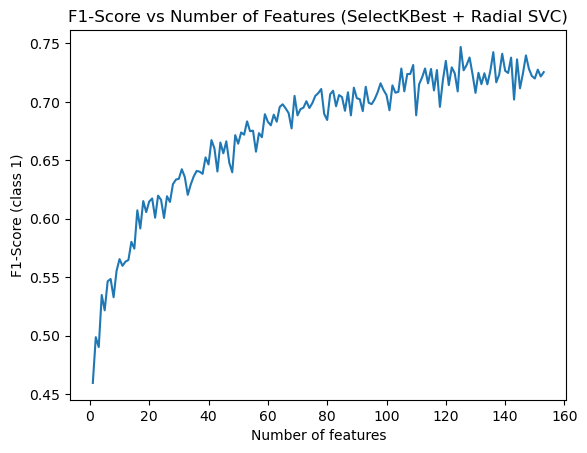

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

n_feats = range(1, len(X.columns)+1)
f1_nfeat = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

for n_feat in n_feats:
    
    f1_cv = []

    for train_index, test_index in kf.split(X, y):
        # Training phase
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]

        # Define classifier with Radial kernel
        clf_cv = SVC(kernel='rbf', class_weight = 'balanced')

        # Feature selection with SelectKBest
        fselection_cv = SelectKBest(f_classif, k=n_feat)
        fselection_cv.fit(X_train, y_train)
        X_train_selected = fselection_cv.transform(X_train)

        # Train classifier
        clf_cv.fit(X_train_selected, y_train)

        # Test phase
        X_test_selected = fselection_cv.transform(X.iloc[test_index, :])
        y_test = y.iloc[test_index]
        y_pred = clf_cv.predict(X_test_selected)

        # Calculate f1-score for class 1
        f1_i = f1_score(y_test, y_pred, pos_label=1)
        f1_cv.append(f1_i)

    # Average f1-score for this number of features
    f1_avg = np.average(f1_cv)
    f1_nfeat.append(f1_avg)

# Find optimal number of features
opt_index = np.argmax(f1_nfeat)
opt_features = n_feats[opt_index]
opt_f1_score = f1_nfeat[opt_index]
print("Optimal number of features: ", opt_features)
print("F1-Score (class 1) with optimal number of features: ", opt_f1_score)

# Plot f1-score vs number of features
plt.plot(n_feats, f1_nfeat)
plt.xlabel("Number of features")
plt.ylabel("F1-Score (class 1)")
plt.title("F1-Score vs Number of Features (SelectKBest + Radial SVC)")
plt.show()

#### 5. Repite el paso anterior, pero para un método de selección de características secuencial.

##### Feature Selection: Sequential method

In [29]:
from sklearn.feature_selection import SequentialFeatureSelector

In [30]:
n_feats = range(1, len(X.columns)+1)
f1_nfeat = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

for n_feat in n_feats:

    
    f1_cv = []

    for train_index, test_index in kf.split(X, y):
        # Training phase
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]

        # Define LDA classifier
        clf_cv = LinearDiscriminantAnalysis(priors=[prior_0, prior_1])

        # Sequential Feature Selector
        fselection_cv = SequentialFeatureSelector(clf_cv, n_features_to_select=n_feat, direction='forward', cv=3)
        fselection_cv.fit(X_train, y_train)
        X_train_selected = fselection_cv.transform(X_train)

        # Train classifier
        clf_cv.fit(X_train_selected, y_train)

        # Test phase
        X_test_selected = fselection_cv.transform(X.iloc[test_index, :])
        y_test = y.iloc[test_index]
        y_pred = clf_cv.predict(X_test_selected)

        # Calculate f1-score for class 1
        f1_i = f1_score(y_test, y_pred, pos_label=1)
        f1_cv.append(f1_i)
        

    # Average f1-score for this number of features
    f1_avg = np.average(f1_cv)
    f1_nfeat.append(f1_avg)
    

# Find optimal number of features
opt_index = np.argmax(f1_nfeat)
opt_features = n_feats[opt_index]
opt_f1_score = f1_nfeat[opt_index]

print("Optimal number of features: ", opt_features)
print("F1-Score (class 1) with optimal number of features: ", opt_f1_score)

# Plot f1-score vs number of features
plt.plot(n_feats, f1_nfeat)
plt.xlabel("Number of features")
plt.ylabel("F1-Score (class 1)")
plt.title("F1-Score vs Number of Features (Sequential Feature Selector + LDA)")
plt.show()

KeyboardInterrupt: 

### 6. Ahora para un método de selección de características recursivo.

#### Feature Selection: RFE method

In [ ]:
from sklearn.feature_selection import RFE

In [ ]:
# Inicialización de variables
n_feats = range(1, len(X.columns)+1)
f1_nfeat = []

kf = StratifiedKFold(n_splits=5, shuffle=True)

for n_feat in n_feats:
    
    print(f'---- n features = {n_feat}')
    
    f1_cv = []

    for train_index, test_index in kf.split(X, y):
        # Fase de entrenamiento
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index]

        # Definir clasificador con kernel lineal
        clf_cv = SVC(kernel='linear', class_weight='balanced')

        # Selección de características con RFE
        rfe_cv = RFE(estimator=clf_cv, n_features_to_select=n_feat)
        rfe_cv.fit(X_train, y_train)
        X_train_selected = rfe_cv.transform(X_train)

        # Entrenar clasificador
        clf_cv.fit(X_train_selected, y_train)

        # Fase de prueba
        X_test_selected = rfe_cv.transform(X.iloc[test_index, :])
        y_test = y.iloc[test_index]
        y_pred = clf_cv.predict(X_test_selected)

        # Calcular f1-score para la clase 1
        f1_i = f1_score(y_test, y_pred, pos_label=1)
        f1_cv.append(f1_i)

    # F1-score promedio para esta cantidad de características
    f1_avg = np.average(f1_cv)
    f1_nfeat.append(f1_avg)
    
    print(f'F1-Score (class 1): {f1_avg}')

# Encontrar el número óptimo de características
opt_index = np.argmax(f1_nfeat)
opt_features = n_feats[opt_index]
opt_f1_score = f1_nfeat[opt_index]
print("Optimal number of features: ", opt_features)
print("F1-Score (class 1) with optimal number of features: ", opt_f1_score)

# Graficar f1-score vs número de características
plt.plot(n_feats, f1_nfeat)
plt.xlabel("Number of features")
plt.ylabel("F1-Score (class 1)")
plt.title("F1-Score vs Number of Features (RFE + Linear SVC)")
plt.show()

### 7. Escoge alguna de las técnicas de selección de características que probaste con anteioridad, y con el número óptimo de características encontrado, prepara tu modelo para producción

#### Modelo final: Radial SVC con 128 caracteristicas

In [50]:
# Selección de las 128 mejores características
num_features = 128
fselection = SelectKBest(f_classif, k=num_features)
X_selected = fselection.fit_transform(X, y)

In [54]:
# Definir clasificador con kernel radial (RBF)
clf = SVC(kernel='rbf', class_weight='balanced')

In [55]:
# Entrenar el clasificador con todos los datos
clf.fit(X_selected, y)

SVC(class_weight='balanced')

In [56]:
# Guardar el modelo en un archivo pickle
'''
with open('radial_svc_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

print("Modelo Radial SVC guardado en 'radial_svc_model.pkl'")
'''

'\nwith open(\'radial_svc_model.pkl\', \'wb\') as model_file:\n    pickle.dump(clf, model_file)\n\nprint("Modelo Radial SVC guardado en \'radial_svc_model.pkl\'")\n'

### 8. Conclusiones

Contesta las siguientes preguntas:

- A) ¿Qué pasa si no se considera el problema de tener datos desbalanceados para este caso? ¿Por qué?

Si no se balancean las clases del conjunto de datos al entrenar un modelo de machine learning, vamos a obtener un modelo que no sepa clasificar la clase minoritaria. Esto se va a traducir en un modelo con muy buen accuracy, pero un mal recall para la clase minoritaria.

- B) De todos los clasificadores, ¿cuál o cuales consideras que son adecuados para los datos? ¿Qué propiedades tienen dichos modelos que los hacen apropiados para los datos? Argumenta tu respuesta.

Dos de los tres mejores modelos fueron lineales, estos fueron LDA y LinearSVC. Sin embargo, el mejor modelo fue el RadialSVC, el cual es un modelo computacionalmente caro pero capaz de trazar un hiperplano no lineal que clasifique con precisión las observaciones de las distintas clases.

- C) ¿Es posibles reducir la dimensionalidad del problema sin perder rendimiento en el modelo? ¿Por qué?

Es posible, tanto con métodos de selección de características como de reducción de dimensionalidad. Esto se debe a que, al haber tantas características, pueden existir algunas que no estén aportando información valiosa debido a problemas como colinealidad. Por lo tanto, se pueden prescindir de estas características, o crear un número reducido de nuevas características que sumen un porcentaje alto de varianza explicada de la variable objetivo.
 
- D) ¿Qué método de selección de características consideras el más adecuado para este caso? ¿Por qué?

Considero que el método de filtrado es el mejor por el simple hecho de que el costo computacional es significativamente menor a los otros dos métodos.

- E) Si quisieras mejorar el rendimiento de tus modelos, ¿qué más se podría hacer?

Se podría hacer un ajuste de hiperparámetros a los mejores modelos para asi encontrar los hiperparámetros óptimos.